In [1]:
from IPython.display import Image

# Lab 3 - Fully Connected Feedforward Network with MNIST


In this lab, we will train a fully connected feedforward network on MNIST data. 

In [2]:
# Figure 1
Image(url= "http://3.bp.blogspot.com/_UpN7DfJA0j4/TJtUBWPk0SI/AAAAAAAAABY/oWPMtmqJn3k/s1600/mnist_originals.png", width=200, height=200)

<a id='#Model Creation'></a>
## Lab model
Our multi-layer perceptron will be relatively simple with 2 hidden layers (`num_hidden_layers`). The number of nodes in the hidden layer being a parameter specified by `hidden_layers_dim`. The figure below illustrates the entire model we will use in this tutorial in the context of MNIST data.

![model-mlp](http://cntk.ai/jup/cntk103c_MNIST_MLP.png)

## Initialize environment

In [3]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

import cntk as C

# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(0))

%matplotlib inline

## Data reading

In this tutorial we are using the MNIST data you have downloaded using CNTK_103A_MNIST_DataLoader notebook. The dataset has 60,000 training images and 10,000 test images with each image being 28 x 28 pixels. Thus the number of features is equal to 784 (= 28 x 28 pixels), 1 per pixel. The variable `num_output_classes` is set to 10 corresponding to the number of digits (0-9) in the dataset.

The data is in the following format:

    |labels 0 0 0 0 0 0 0 1 0 0 |features 0 0 0 0 ... 
                                                  (784 integers each representing a pixel)
    
In this tutorial we are going to use the image pixels corresponding the integer stream named "features". We define a `create_reader` function to read the training and test data using the [CTF deserializer](https://cntk.ai/pythondocs/cntk.io.html?highlight=ctfdeserializer#cntk.io.CTFDeserializer). The labels are [1-hot encoded](https://en.wikipedia.org/wiki/One-hot). Refer to CNTK 103A tutorial for data format visualizations. 


In [4]:
# Ensure we always get the same amount of randomness
np.random.seed(0)

# Define the data dimensions
input_dim = 784
num_output_classes = 10

# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    return C.io.MinibatchSource(C.io.CTFDeserializer(path, C.io.StreamDefs(
        labels = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
        features   = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [7]:
num_hidden_layers = 2
hidden_layers_dim = 400

In [8]:
input = C.input(input_dim)
label = C.input(num_output_classes)

## Model training

### Set up a computational network


In [9]:
# Define a fully connected feedforward classification network with sigmoid neurons in the hidden layers
def create_model(features, num_hidden_layers, hidden_layers_dim, num_output_classes):
    with C.layers.default_options(init = C.layers.glorot_uniform(), activation = C.ops.relu):
        h = features
        for _ in range(num_hidden_layers):
            h = C.layers.Dense(hidden_layers_dim)(h)
        r = C.layers.Dense(num_output_classes, activation = None)(h)
        return r
    
# Configure a two hidden-layer FCN with softmax output and cross-entropy loss
input_dim = 784
num_hidden_layers = 2
hidden_layers_dim = 400
num_output_classes = 10

features = C.input(input_dim)
labels = C.input(num_output_classes)

z = create_model(features/255.0, num_hidden_layers, hidden_layers_dim, num_output_classes)


### Define loss and error functions

In [10]:
loss = C.cross_entropy_with_softmax(z, labels)
error = C.classification_error(z, labels)


### Configure a trainer with the SGD learner


In [12]:
# Configure a trainer with the SGD learner
learning_rate = 0.2
lr_schedule= C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
learner = C.sgd(z.parameters, lr_schedule)
progress_printer = ProgressPrinter(500)
trainer = C.Trainer(z, (loss, error), [learner], [progress_printer])


### Run the trainer



In [13]:
# Create and prime the reader with the training dataset
train_file = '../../Data/MNIST_train.txt'
reader_train = create_reader(train_file, True, input_dim, num_output_classes)

# Map the data streams to the features and labels
input_map = {
    labels : reader_train.streams.labels,
    features: reader_train.streams.features
}

In [ ]:
# Configure sweeps and minibatches
minibatch_size = 64
num_samples_per_sweep = 50000
num_sweeps_to_train_with = 10
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size

# Run the trainer
start_time = time.time()
for _ in range(0, int(num_minibatches_to_train)):
    data = reader_train.next_minibatch(minibatch_size, input_map = input_map)
    trainer.train_minibatch(data)
print(time.time() - start_time)


## Model evaluation

In [19]:
out = C.softmax(z)

Let us a small minibatch sample from the test data.

In [20]:
# Read the data for evaluation
reader_eval = create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 25
eval_input_map = {input: reader_eval.streams.features} 

data = reader_test.next_minibatch(eval_minibatch_size, input_map = test_input_map)

img_label = data[label].asarray()
img_data = data[input].asarray()
predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]

In [21]:
# Find the index with the maximum value for both predicted as well as the ground truth
pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]

In [22]:
print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [4, 5, 6, 7, 8, 9, 7, 4, 6, 1, 4, 0, 9, 9, 3, 7, 8, 4, 7, 5, 8, 5, 3, 2, 2]
Predicted: [4, 6, 6, 7, 8, 9, 7, 4, 6, 1, 4, 0, 9, 9, 3, 7, 8, 0, 7, 5, 8, 5, 3, 2, 2]


Let us visualize some of the results

Image Label:  9


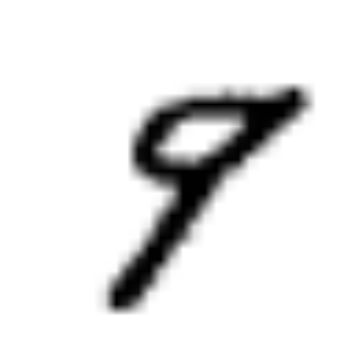

In [23]:
# Plot a random image
sample_number = 5
plt.imshow(img_data[sample_number].reshape(28,28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)

**Exploration Suggestion**
-  Try exploring how the classifier behaves with different parameters - suggest changing the `minibatch_size` parameter from 25 to say 64 or 128. What happens to the error rate? How does the error compare to the logistic regression classifier?
- Suggest trying to increase the number of sweeps
- Can you change the network to reduce the training error rate? When do you see *overfitting* happening?

#### Code link

If you want to try running the tutorial from Python command prompt please run the [SimpleMNIST.py](https://github.com/Microsoft/CNTK/tree/v2.0.rc2/Examples/Image/Classification/MLP/Python) example.